Here I report the results of the training of the model for the weakly interacting regime.

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import math
import quimb as qu

from matplotlib.colors import LogNorm, Normalize
from pathlib import Path
from quimb.tensor.tensor_1d import MatrixProductOperator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

from models import SpinChain
from ml.classes import MLLP
from ml.utils import calculate_error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
prms = {'L' : 20,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        'beta' : [1],            # inverse temperature
        # interaction of subsystem's S spins
        'potential' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.5],       
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.01,             # interval every which save the data
        'cutoff' : 1e-5,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-10,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-3,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 30,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd.hdf5'
        }

ml_params = {'model_dir': './data/trained_unc_td_prova', # folder where the metadata of the training are stored
             'validation_split' : 0.8,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 30,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt' : 0.01
                 },
             }

# Functions

In [3]:
def print_comparison(data_tebd, data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][columns*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml[k][columns*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [4]:
def print_comparison_3(data_tebd, data_ml, data_ml_2, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][columns*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml_2[k][columns*i+j] for k in range(len(t))], label='ml', color='b', linestyle='--', alpha=0.6)
            axs[i, j].plot(t, [data_ml[k][columns*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [5]:
def print_ml_dyn(data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_ml[k][columns*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [6]:
def error_asymptotic_rho(L, potential, T_train, model_dir, data_file, td=False, beta=1):
    """Comparison between the thermal state and the asymptotic
    state reached by the model
    """
    
    ### INITIAL THERMAL STATE
    # building the thermal state
    chain = SpinChain(L=L, omega=1, beta=1, potential=potential, T=0,
                     dt=0.01, cutoff=1e-5, im_cutoff=1e-10,
                     tolerance=1e-3, verbose=False)
    chain.thermalize()

    # taking the trace over the bath
    rho = chain.psi_th.partial_trace((1,2), rescale_sites=True)

    # to trace out the ancillas I build another MPO
    tn1 = np.empty((rho['I1'].shape[0], 2, 2), dtype=complex)
    tn2 = np.empty_like(tn1)

    for i in range(tn1.shape[0]):
        tn1[i][0][0] = rho['I0'].data[i][0][0] + rho['I0'].data[i][1][1]
        tn1[i][1][1] = rho['I0'].data[i][2][2] + rho['I0'].data[i][3][3]
        tn1[i][0][1] = rho['I0'].data[i][2][0] + rho['I0'].data[i][3][1]
        tn1[i][1][0] = rho['I0'].data[i][0][2] + rho['I0'].data[i][1][3]

        tn2[i][0][0] = rho['I1'].data[i][0][0] + rho['I1'].data[i][1][1]
        tn2[i][1][1] = rho['I1'].data[i][2][2] + rho['I1'].data[i][3][3]
        tn2[i][0][1] = rho['I1'].data[i][2][0] + rho['I1'].data[i][3][1]
        tn2[i][1][0] = rho['I1'].data[i][0][2] + rho['I1'].data[i][1][3]

    rho_th = MatrixProductOperator([tn1, tn2]).contract()

    # make a 4x4 matrix
    rho_th = np.matrix(rho_th.fuse_({'k':['k0','k1'], 'b':['b0', 'b1']}).data)
    # normalization, just to be sure
    rho_th /= rho_th.trace().real
    
    ### MODEL PREDICTION
    # import the model
    name = 'model_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
            '_T' + str(T_train).zfill(2)

    model = MLLP(ml_params['mlp_params'], potential, td).to(ml_params['device'])
    model.load_state_dict(torch.load(Path('./data/'+ model_dir + name)))
    
    
    # import TEBD data
    gname = 'cohVec_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_beta_' + str(int(beta*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
    with h5py.File('./data/'+data_file, 'r') as f:
        data_tebd = f[gname+'/X'][()]
        
    v_inf = model.thermal_state(data_tebd[0], 1)
        
    # base elements
    F = []
    pauli = {'I' : qu.pauli('I'),
            'X' : qu.pauli('X'),
            'Y' : qu.pauli('Y'),
            'Z' : qu.pauli('Z')}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        F.append(0.5*pauli[ob1]&pauli[ob2])
    
    # building the density matrix
    rho_ml = np.matrix(np.eye(4, dtype=complex)/4)
    
    for i in range(15):
        rho_ml += v_inf[i]*F[i+1]
    
    # normalization
    rho_ml /= rho_ml.trace()
        
    print( qu.calc.trace_distance(rho_th, rho_ml))
    return 0.5*qu.linalg.base_linalg.norm(rho_th - rho_ml, ntype='t')

In [7]:
def asymptotic_value_test(L, potential, T_train, model_dir, data_file, beta=1):
    """Here I test that the asymptotic value of the Lindblad
    is a well behaved density matrix, for different initial coditions
    """
    # base elements
    F = []
    pauli = {'I' : qu.pauli('I'),
            'X' : qu.pauli('X'),
            'Y' : qu.pauli('Y'),
            'Z' : qu.pauli('Z')}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        F.append(0.5*pauli[ob1]&pauli[ob2])

    # import TEBD data
    gname = 'cohVec_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_beta_' + str(int(beta*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
    with h5py.File('./data/'+data_file, 'r') as f:
        data_tebd = f[gname+'/X'][()]
            
    # import the model
    name = 'model_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
            '_T' + str(T_train).zfill(2)

    model = MLLP(ml_params['mlp_params'], potential).to(ml_params['device'])
    model.load_state_dict(torch.load(Path('./data/'+model_dir + name)))
    
    for i in range(30):
        print(f'Initial v: \n {data_tebd[i*999]}\n')

        v_inf = model.thermal_state(data_tebd[i*999], beta)
        v = np.zeros(16)
        v[0] = 0.5
        v[1:] = v_inf
        print(model.MLP.get_L()@v)

        # building the density matrix
        rho_ml_inf = np.matrix(np.eye(4, dtype=complex)/4)

        for i in range(15):
            rho_ml_inf += v_inf[i]*F[i+1]
        print(f'Final density matrix: \n{rho_ml_inf}\n')
            
        print(rho_ml_inf.trace())
        print(qu.isherm(rho_ml_inf))
        print(qu.ispos(rho_ml_inf))    

In [8]:
def diagonalization_test(L, potential, T_train, model_dir, data_file, td, beta=1):
    """Here I test if the density matrix obatined from the diagonalization
    is the same as directly evolving the state
    """
    # base elements
    F = []
    pauli = {'I' : qu.pauli('I'),
            'X' : qu.pauli('X'),
            'Y' : qu.pauli('Y'),
            'Z' : qu.pauli('Z')}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        F.append(0.5*pauli[ob1]&pauli[ob2])

    # import TEBD data
    gname = 'cohVec_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_beta_' + str(int(beta*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
    with h5py.File('./data/'+data_file, 'r') as f:
        data_tebd = f[gname+'/X'][()]
            
    # import the model
    name = 'model_L_' + str(L) + \
            '_V_' + str(int(potential*1e3)).zfill(4) + \
            '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
            '_T' + str(T_train).zfill(2)

    model = MLLP(ml_params['mlp_params'], potential=potential, time_dependent=td).to(ml_params['device'])
    model.load_state_dict(torch.load(Path('./data/'+model_dir + name)))
    
    # explicit evolution
    v_inf = model.thermal_state(data_tebd[0], 1)
    
    # diagonalization
    Lindblad = model.MLP.get_L(1587)
    e_val, e_vec = np.linalg.eig(Lindblad.detach().numpy())
    
    print(f'Zero eigenvalue : {e_val[-1]}\n')
    normalization = 1 - math.e**(-beta/2)
    if potential > 1:
        normalization /= potential**2
    v_ev = e_vec[:,-1] * normalization
    
    print('Norm of the difference of the coherence vectors: \n')
    print(np.abs(v_ev[1:] - v_inf))
    
    # building the density matrix
    rho_ml_inf = np.matrix(np.eye(4, dtype=complex)/4)
    rho_ml_ev = rho_ml_inf*0
    
    for i in range(15):
        rho_ml_inf += v_inf[i]*F[i+1]
        rho_ml_ev += v_ev[i]*F[i]
    rho_ml_ev += v_ev[15]*F[15]
    
    # normalization
    rho_ml_ev = rho_ml_ev / rho_ml_ev.trace()
    print(f'Rho inf trace: {rho_ml_inf.trace()}')
    print(f'Rho ev trace:  {rho_ml_ev.trace()}')
    print(f'Rho inf is herm  {qu.isherm(rho_ml_inf)}')
    print(f'Rho ev is herm  {qu.isherm(rho_ml_ev)}')
    print(f'Rho inf is pos  {qu.ispos(rho_ml_inf)}')
    print(f'Rho ev is pos  {qu.ispos(rho_ml_ev)}')
    
    print(f'Trace distance {qu.calc.trace_distance(rho_ml_inf, rho_ml_ev)}')

In [9]:
def print_omega(model, T, ylim=1, dt=0.01):
    time = np.arange(0, T, dt)
    
    rows= 5
    columns = 3
    
    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))
    
    model.eval()
    for i in range(rows):
        for j in range(columns):
            omega_learned = np.array([model.MLP.get_omega(t)[columns*i+j] for t in time])
            axs[i, j].plot(time, omega_learned, label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            #axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [10]:
def print_rates(model, T, ylim=1, dt=0.01):
    time = np.arange(0, T, dt)
    
    rows= 5
    columns = 3
    
    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    model.eval()
    for i in range(rows):
        for j in range(columns):
            omega_learned = np.array([model.MLP.get_rates(t)[columns*i+j] for t in time])
            axs[i, j].plot(time, omega_learned, label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            #axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [ ]:
diagonalization_test(L=60, potential=0.5, T_train=10, model_dir='trained_unc_td/', 
                     data_file='data_unc_training.hdf5', td=True)

In [ ]:
rho_testing(L=60, potential=0.1, T_train=10, model_dir='trained_unc_W/')

# Does it extrapolate?
I want to see if the model is able to extrapolate the dynamics fo further time respect ot the training window.

## L = 20
In this case I compare different time windows for the training, at fixed L.
The comaprison is made with a simulation up to T/\Omega = 20.

In [ ]:
# for each combinations of potential and training T

T_max = 20
beta = 1
fname = './data/data_test_W.hdf5'

training_times = [3,4,5,6,7,8,9,10]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors_1 = []

for T_train in training_times:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(fname, 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_1.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_1, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = training_times
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$T_{train}/\Omega$')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/extrapolation_W.pdf', dpi=150)

In [ ]:
L = 40
T_train = 10
vv = 0.2
# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File(fname, 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.6)

## Comparison L = 20, 40, 60
Here I fix the training window at T/\Omega = 4 and compare for different L.
The comaprison is made with a simulation up to T/\Omega = 20.

In [ ]:
# for each combinations of potential and L I calculate the error

T_max = 20
T_train = 4
beta = 1

L = [20, 40, 60]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors_2 = []

for l in L:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        #print(gname)
        with h5py.File('./data/data_test_W.hdf5', 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_2.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_2, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_W.pdf', dpi=150)

In [ ]:
T_train = 4
vv = 0.5
L = 60
# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File('./data/data_test_W.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.6)

## Thermalization
I want to see if the thermal state reached by the model is the same as the initial condition, it should be.

In [ ]:
# for each combinations of potential and L I calculate the error
T_train = 4
L = [20, 40, 60]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tr_distance_1 = []

for l in L:
    err = []
    for vv in potential:
        # calculate error
        err.append(error_asymptotic_rho(L=l, potential=vv, T_train=T_train, 
                                          model_dir='trained_W/', data_file='data_test_W.hdf5'))
    tr_distance_1.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(tr_distance_1, origin='lower', cmap='RdYlBu', norm=Normalize(vmin=0.2, vmax=0.4))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/asymptotic_rho_W.pdf', dpi=1503

In [ ]:
T_train = 4
T_max = 200
vv = 0.5
L = 60

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

rows= 5
columns = 3
names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
plt.setp(axs, xlim=(T_max-10,T_max), ylim=(-0.5, 0.5))
t = np.arange(0, T_max, prms['dt'])[:-1]

for i in range(rows):
    for j in range(columns):
        #if i == rows-1 & j == columns-1:
        #    continue
        axs[i, j].plot(t[-1000:], [ml_dyn[k][(columns-1)*i+j] for k in range(len(t)-1000,len(t))], label='ml', color='r')
        axs[i, j].grid()
        axs[i, j].set_title(names[(columns-1)*i+j], x=0.5, y=0.85)
axs[4, 2].grid()
#plt.legend()
plt.grid()

fig = plt.gcf()
plt.show()

In [ ]:
np.sort(model.MLP.gap())

# Uncorrelated initial conditions

Here I do the same thing I did before, but I use data with a different iniital conditions, namley the initial state is now separable, which should make the system "more Markovian".

## L = 20

In [ ]:
# for each combinations of potential and length L

T_max = 20
beta = 1
fname = './data/data_unc_test_W.hdf5'

training_times = [3,4,5,6,7,8,9,10]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors_3 = []

for T_train in training_times:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(fname, 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_unc_W/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_3.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_3, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = training_times
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$T_{train}/\Omega$')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/extrapolation_unc_W.pdf', dpi=150)

In [ ]:
L = 20
T_max = 20
T_train = 10
vv = 0.5

# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File('./data/data_unc_test_W.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_W/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.2)

In [ ]:
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=100, beta=1)
print_ml_dyn(ml_dyn, 100, dt=0.01, ylim=0.15)

## Comparison L = 20, 40, 60, 80
Here I fix the training window at T/\Omega = 10 and compare for different L.
The comaprison is made with a simulation up to T/\Omega = 20.

In [ ]:
# for each combinations of potential and L I calculate the error

T_max = 20
T_train = 10
beta = 1

L = [20, 40, 60, 80]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors_4 = []

for l in L:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        #print(gname)
        with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params'], potential=vv).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_unc/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_4.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_4, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_unc_W.pdf', dpi=150)

## Finite size effects

In [ ]:
# load and shift data
T = 20
vv = 0.5
L = 20
t = np.arange(0, T, 0.1)

# import TEBD data
gname = 'correlations_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_T_' + str(int(T)).zfill(2)
#print(gname)
with h5py.File('./data/data_correlations.hdf5', 'r') as f:
    cx = f[gname+'/x'][()].tolist()
    cy = f[gname+'/y'][()].tolist()
    cz = f[gname+'/z'][()].tolist()


for i in range(len(t)):
    shift_to_half(cx[i])
    shift_to_half(cy[i])
    shift_to_half(cz[i])

In [ ]:
def shift_to_half(ll):
    length = len(ll)
    
    ll.extend( ll[:int(length/2)] )
    ll[:int(length/2)] = []

In [ ]:
### plot with themal initial state total
#with plt.style.context(qu.NEUTRAL_STYLE):
plt.figure(figsize=(12, 7))
print(f'V = {vv}')

t = np.arange(0, T, 0.1)
jb = np.linspace(0, L)
vmin = 0
vmax= 0.001

# plot the magnetization
ax1 = plt.subplot(131)
plt.pcolormesh(js, t, np.abs(cx), vmin=vmin, vmax=vmax)
plt.set_cmap('binary')
plt.colorbar()
plt.title('abs X-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

ax2 = plt.subplot(132, sharey=ax1)
plt.pcolormesh(js, t, np.abs(cy), vmin=vmin, vmax=vmax)
plt.set_cmap('binary')
plt.colorbar()
plt.title('abs Y-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

ax3 = plt.subplot(133, sharey=ax1)
plt.pcolormesh(js, t, np.abs(cz), vmin=vmin, vmax=vmax)
plt.set_cmap('binary')
plt.colorbar()
plt.title('abs Z-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

plt.tight_layout()
plt.show()

In [ ]:
cx[-1]

In [ ]:
### plot with themal initial state total
#with plt.style.context(qu.NEUTRAL_STYLE):
plt.figure(figsize=(12, 7))

t = np.arange(0, T, 0.1)
jb = np.linspace(0, L)
vmin = -0.001
vmax=0.001

# plot the magnetization
ax1 = plt.subplot(131)
plt.pcolormesh(js, t, cx, vmin=vmin, vmax=vmax)
plt.set_cmap('RdBu')
plt.colorbar()
plt.title('X-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

ax2 = plt.subplot(132, sharey=ax1)
plt.pcolormesh(js, t, cy, vmin=vmin, vmax=vmax)
plt.set_cmap('RdBu')
plt.colorbar()
plt.title('Y-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

ax3 = plt.subplot(133, sharey=ax1)
plt.pcolormesh(js, t, cz, vmin=vmin, vmax=vmax)
plt.set_cmap('RdBu')
plt.colorbar()
plt.title('Z-Correlations')
plt.xlabel('Site')
plt.ylabel('time [ $Jt$ ]')

plt.tight_layout()
plt.show()

In [ ]:
cx[0]

## Thermalization

In [ ]:
# for each combinations of potential and L I calculate the error
T_train = 10
beta = 1
L = [20, 40, 60, 80]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tr_distance_2 = []

for l in L:
    err = []
    for vv in potential:
        
        # calculate error
        err.append(error_asymptotic_rho(L=l, potential=vv, T_train=T_train, model_dir='trained_unc/',
                                      data_file='data_unc_test.hdf5'))
    tr_distance_2.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(tr_distance_2, origin='lower', cmap='RdYlBu', norm=Normalize(vmin=0.2, vmax=0.3))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/thermal_unc_W.pdf', dpi=150)

# Non-Markovian

## L = 20

In [ ]:
# for each combinations of potential and length L

L = 20
T_max = 20
beta = 1

training_times = [10]
potential = [0.5]

errors_5 = []

for T_train in training_times:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(L) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params'], potential=vv, time_dependent=True).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_unc_td_prova/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_5.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_5, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = training_times
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$T_{train}/\Omega$')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/extrapolation_unc_W_td.pdf', dpi=150)

## Comparison L = 20, 40, 60 ,80
Here I fix the training window at T/\Omega = 10 and compare for different L.
The comaprison is made with a simulation up to T/\Omega = 20.

In [ ]:
# for each combinations of potential and L I calculate the error

T_max = 20
T_train = 10
beta = 1

L = [20, 40, 60, 80]
potential = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

errors_6 = []

for l in L:
    err = []
    for vv in potential:
        # import TEBD data
        gname = 'cohVec_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        #print(gname)
        with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(l) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(T_train).zfill(2)

        model = MLLP(ml_params['mlp_params'], potential=vv, time_dependent=True).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_unc_td/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=T_max, dt=prms['dt']))
    errors_6.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(errors_6, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/length_dependance_unc_W_td.pdf', dpi=150)

## Prove

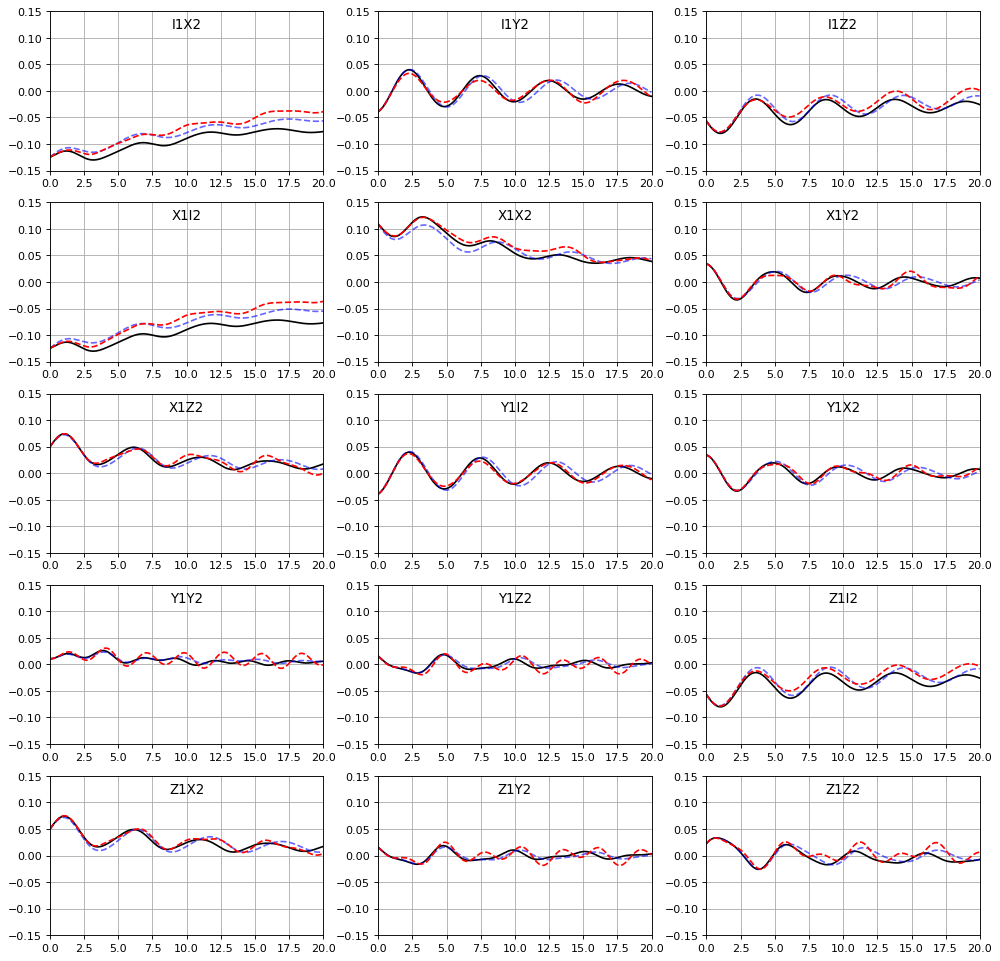

In [47]:
L = 20
T_train = 10
vv = 0.5
beta = 1
T_max = 20

# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params'], potential = vv, time_dependent=True).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_unc_td_prova/' + name)))
model.eval()

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison_3(data_tebd, ml_dyn, ml_dyn_TI, T_max, dt=0.01, ylim=0.15)
#print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.15)

In [48]:
#model.MLP.v_x_net[-2].weight[1]
#model.MLP.omega_net.weights
u = model.MLP.u_re + 1j*model.MLP.u_im
#print(qu.isherm(u.detach().numpy()))
#print((u.H@u).detach().numpy().round())
torch.abs(torch.trace(torch.eye(15) - (u.H@u).detach()))

tensor(9.5367e-07)

In [ ]:
print(model.MLP.v_x_net[1].a)
print(model.MLP.v_x_net[1].b)
print(model.MLP.v_y_net[1].a)
print(model.MLP.v_y_net[1].b)

#print(model.MLP.v_y_net[3].a)

In [49]:
model.MLP.omega_net.frequencies

Parameter containing:
tensor([ 0.9851,  2.1813,  4.6444, 10.1065, 21.6027, 46.4703, 99.9597],
       requires_grad=True)

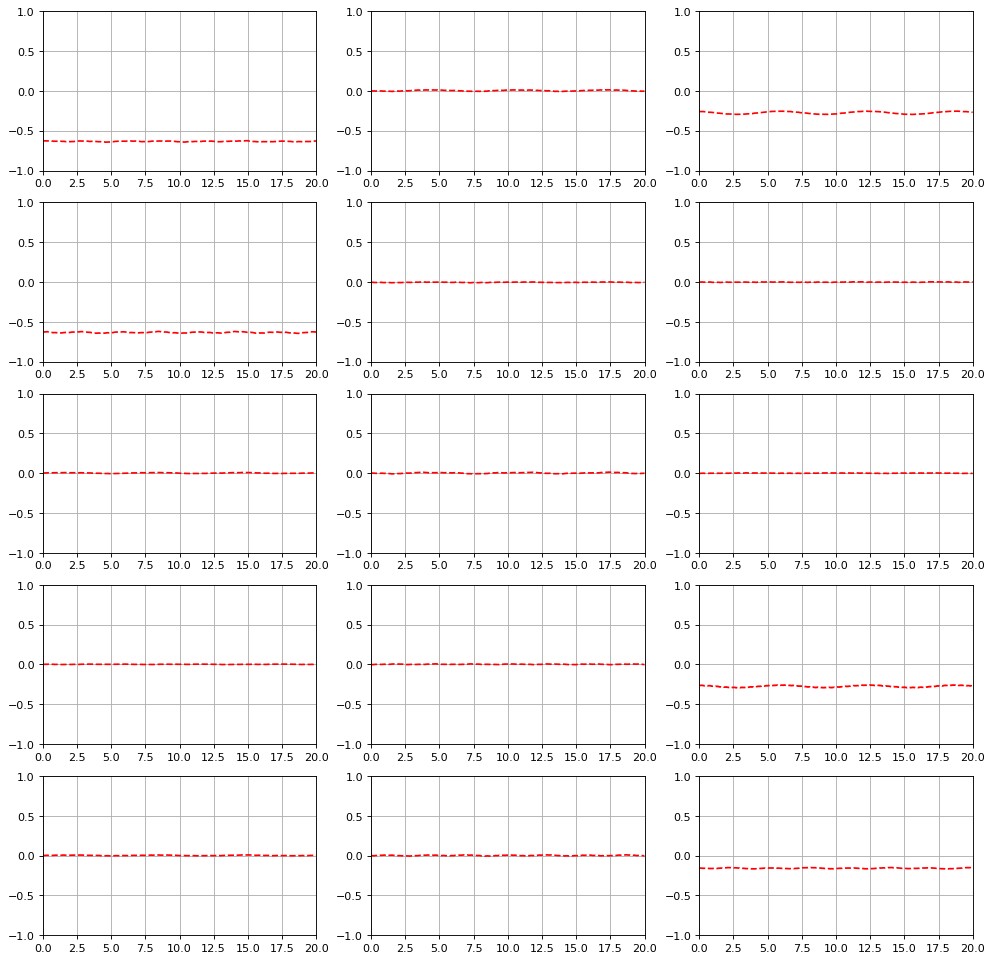

In [50]:
print_omega(model, 20, ylim=1)

In [46]:
model.MLP.gamma_net.frequencies

Parameter containing:
tensor([  1.0102,   1.2489,   1.6276,   2.1099,   2.5550,   3.3207,   4.2850,
          5.4892,   6.9135,   8.8141,  11.2815,  14.3987,  18.3138,  23.3714,
         29.7752,  37.9332,  48.3375,  61.5916,  78.4699, 100.0378],
       requires_grad=True)

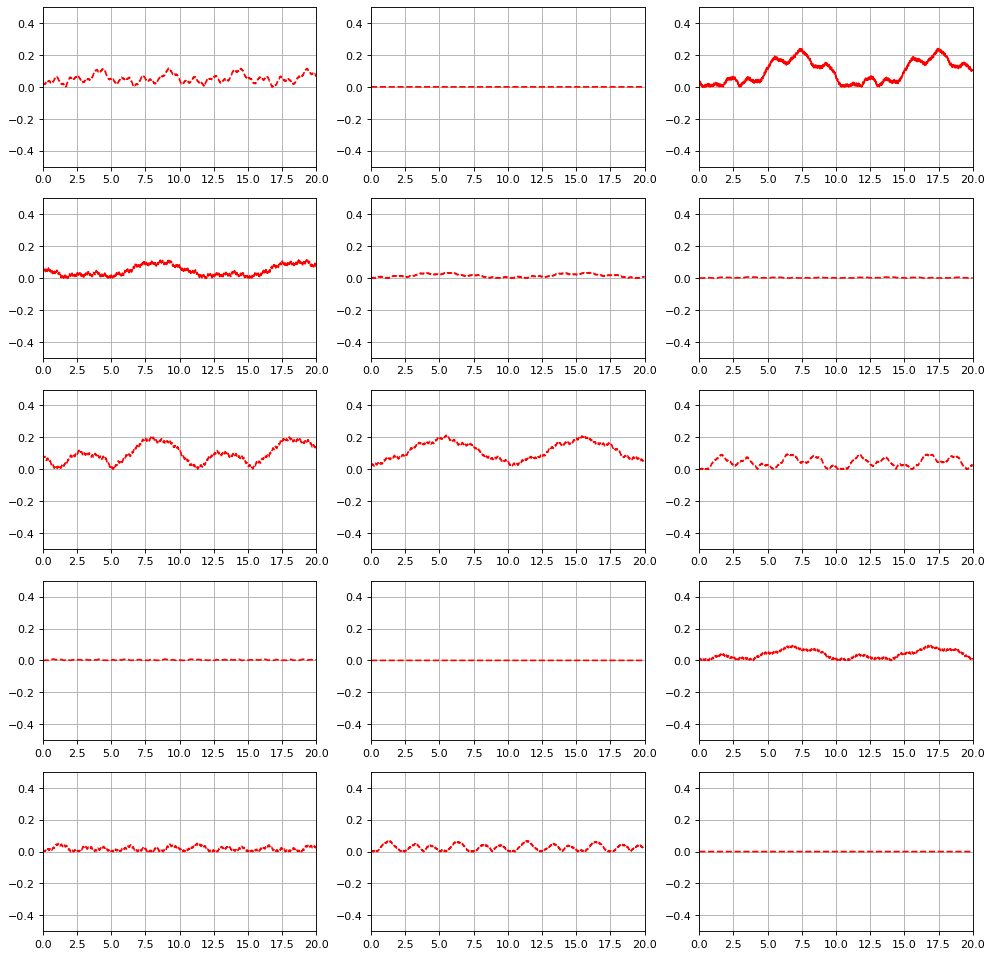

In [51]:
print_rates(model, 20, ylim=0.5)

In [15]:
L=20
vv=0.5
T_train=10
# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params'], potential = vv, time_dependent=False).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_unc/' + name)))
model.eval()

ml_dyn_TI = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=20, beta=1)
#print_comparison(data_tebd, ml_dyn, 20, dt=0.01, ylim=0.15)

In [ ]:
L=20
vv=0.5
T_train=10
# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params'], potential = vv, time_dependent=True).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_unc_td_prova/' + name)))
model.eval()

ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=400, beta=1)
print_ml_dyn(ml_dyn, 400, dt=0.01, ylim=0.15)

In [ ]:
print_ml_dyn(ml_dyn, 400, dt=0.01, ylim=0.015)

## Thermalization

In [ ]:
# for each combinations of potential and L I calculate the error
T_train = 10
beta = 1
L = [20, 40, 60, 80]
potential = [0.1, 0.5, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tr_distance_3 = []

for l in L:
    err = []
    for vv in potential:
        # calculate error
        err.append(error_asymptotic_rho(L=l, potential=vv, T_train=T_train, model_dir='trained_unc_td/',
                                      data_file='data_unc_test.hdf5', td = True))
    tr_distance_3.append(err)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(tr_distance_3, origin='lower', cmap='RdYlBu', norm=Normalize(vmin=0.1, vmax=0.2))

my_x_ticks = potential
my_y_ticks = L
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'L')
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(im, cax=cax)

plt.show()
#fig.savefig('../pictures/thermal_unc_W_td.pdf', dpi=150)

In [ ]:
v_y_net[-1]

In [ ]:
torch.nn.init.normal_(v_y_net[-1].bias)

In [ ]:
v_y_net[-1].bias[1].data = 4.3

In [ ]:
L = 20
T_train = 10
vv = 0.5
T_max = 20

# import TEBD data
gname = 'cohVec_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File('./data/data_unc_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(L) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(T_train).zfill(2)

model = MLLP(ml_params['mlp_params'], potential = vv, time_dependent=True).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_unc_td_plus/' + name)))
model.eval()

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=T_max, beta=beta)

print_comparison(data_tebd, ml_dyn, T_max, dt=0.01, ylim=0.15)

In [ ]:
print_rates(model, )